In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import ldspec
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
import seaborn as sns
import statsmodels.formula.api as smf
from adjustText import adjust_text

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/LDSPEC_data/results/fig_res.rv1'
TAB_PATH = '/n/groups/price/martin/LDSPEC_data/results/tables.rv1'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/trait_info.rv1.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST_INDPT = list(DF_TRAIT.index[DF_TRAIT['Indpt']])
TRAIT_LIST_INDPT_AM = list(DF_TRAIT.index[DF_TRAIT['AM']])
TRAIT_LIST_INDPT_NAM = [x for x in TRAIT_LIST_INDPT if x not in TRAIT_LIST_INDPT_AM]
print("n_trait=%d" % DF_TRAIT.shape[0])
print("n_trait_indpt=%d" % len(TRAIT_LIST_INDPT))
print("n_trait_indpt_am=%d" % len(TRAIT_LIST_INDPT_AM))
print("n_trait_indpt_nam=%d" % len(TRAIT_LIST_INDPT_NAM))

DF_ANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.txt', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {
    'common' : '#78ADD2', 
    'lf' : '#FFB26E',
    ('p0_p100', 'common') : 'C0',
    ('p0_p100', 'lf') : 'C1',
    ('n100_p0', 'common') : 'C2',
    ('n100_p0', 'lf') : 'C3',
}

MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=70
n_trait_indpt=29
n_trait_indpt_am=4
n_trait_indpt_nam=25
n_annot=45
n_pannot=34


### Load results and meta-analysis

In [6]:
# Load results 
DIC_RES_PATH = {
    'md_bsl' : DATA_PATH + '/ldspec_res_092223.bsl/@t',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/ldspec_res_092223.prox_gene_fct_all_ld/@t',
}
md0 = 'md_bsl'

# Load .pickle files: dic_res[md][trait] = .pickle
dic_res = {}
missing_list = []
for md in DIC_RES_PATH:
    dic_res[md] = {}   
    temp_list = TRAIT_LIST if md=='md_prox_gene_fct_all_ld' else TRAIT_LIST_INDPT
    for i,trait in enumerate(temp_list):
        if os.path.exists(DIC_RES_PATH[md].replace("@t", trait) + ".pickle"):
            with open(DIC_RES_PATH[md].replace("@t", trait) + ".pickle", "br") as f:
                dic_res[md][trait] = pickle.load(f)
            # Check avgr
            with open(DIC_RES_PATH[md].replace("@t", trait) + ".sbatch.log", "r") as f:
                for line in f:
                    if 'Detected AVGR for' in line:
                        line = line.strip()
                        n1,n2 = line.split(' ')[3].split('/')
                        if n1!=n2: 
                            print("Missing AVGR: %-20s %-35s %s %s" % (md, trait, i+1, line))
        else:
            print("Missing %-10s %-30s %s" % (md, trait, i+1))
            if trait not in missing_list: 
                missing_list.append(trait)
                
# Check AN_list and pAN_list are same across traits for a given method
print('Check matching of AN_list and pAN_list')
for md in DIC_RES_PATH:
    print('    %s' % md)
    AN_list_md = list(dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['tau'].index)
    pAN_list_md = list(dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['omega'].index)
    for trait in dic_res[md]:
        if set(dic_res[md][trait]['summary']['tau'].index) != set(AN_list_md):
            print('    AN_list not match: %s' % trait)
        if set(dic_res[md][trait]['summary']['omega'].index) != set(pAN_list_md):
            print('    pAN_list not match: %s' % trait)

# Collect info
print('n_missing_trait=%d' % len(missing_list))
AN_list = list(dic_res[md0][TRAIT_LIST_INDPT[0]]['summary']['tau'].index)
print('AN_list=%d' % len(AN_list))
pAN_list = []
for md in DIC_RES_PATH:
    pAN_list += [x for x in dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['omega'].index if x not in pAN_list]
print('pAN_list=%d' % len(pAN_list))

# Trait with h2_z>5
TRAIT_LIST_META = []
for trait in TRAIT_LIST_INDPT:
    h2 = dic_res[md0][trait]['summary']['tau'].loc['AN:all', 'h2']
    h2_se = dic_res[md0][trait]['summary']['tau'].loc['AN:all', 'h2_se']
    h2_z = h2 / h2_se
    if h2_z > 5:
        TRAIT_LIST_META.append(trait)
    else:
        print('    %-20s    h2=%0.3f    h2_z=%0.2f' % (trait, h2, h2_z))
print('%d/%d traits with h2z>5' % (len(TRAIT_LIST_META), len(TRAIT_LIST_INDPT)))

Check matching of AN_list and pAN_list
    md_bsl
    md_prox_gene_fct_all_ld
n_missing_trait=0
AN_list=165
pAN_list=136
29/29 traits with h2z>5


In [7]:
# Meta-analysis
dic_term_list = {
    'tau': ['tau', 'h2', 'scv', 'h2_enrich', 'scv_enrich', 'h2_shrink'], 
    'omega': ['omega', 'cov', 'cor', 'ecov', 'ecor'],
}

dic_res_meta = {}
for md in DIC_RES_PATH:
    dic_res_meta[md] = {}
    res_tau_list = [dic_res[md][x]['summary']['tau'] for x in TRAIT_LIST_META]
    res_omega_list = [dic_res[md][x]['summary']['omega'] for x in TRAIT_LIST_META]
    for res in ['tau', 'omega']:
        dic_res_meta[md][res] = pd.DataFrame(
            index = dic_res[md][TRAIT_LIST_INDPT[0]]['summary'][res].index, 
            columns = ['%s%s'%(x,y) for x in dic_term_list[res] for y in ['', '_se', '_p']],
            dtype=float,
        )
        # Meta-analysis 
        for term in dic_term_list[res]:
            for row in dic_res_meta[md][res].index:
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                dic_res_meta[md][res].loc[row, [term, '%s_se'%term, '%s_p'%term]] = mean_,se_,p_
                
    # meta-analysis across 4 am traits    
    dic_res_meta['%s.am'%md] = {}
    res_tau_list = [dic_res[md][x]['summary']['tau'] for x in TRAIT_LIST_INDPT_AM]
    res_omega_list = [dic_res[md][x]['summary']['omega'] for x in TRAIT_LIST_INDPT_AM]
    for res in ['tau', 'omega']:
        dic_res_meta['%s.am'%md][res] = pd.DataFrame(
            index = dic_res[md][TRAIT_LIST_INDPT[0]]['summary'][res].index, 
            columns = ['%s%s'%(x,y) for x in dic_term_list[res] for y in ['', '_se', '_p']],
            dtype=float,
        )
        # Meta-analysis 
        for term in dic_term_list[res]:
            for row in dic_res_meta['%s.am'%md][res].index:
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                dic_res_meta['%s.am'%md][res].loc[row, [term, '%s_se'%term, '%s_p'%term]] = mean_,se_,p_

    # meta-analysis across 25 non-am traits    
    dic_res_meta['%s.nam'%md] = {}
    res_tau_list = [dic_res[md][x]['summary']['tau'] for x in TRAIT_LIST_INDPT_NAM]
    res_omega_list = [dic_res[md][x]['summary']['omega'] for x in TRAIT_LIST_INDPT_NAM]
    for res in ['tau', 'omega']:
        dic_res_meta['%s.nam'%md][res] = pd.DataFrame(
            index = dic_res[md][TRAIT_LIST_INDPT[0]]['summary'][res].index, 
            columns = ['%s%s'%(x,y) for x in dic_term_list[res] for y in ['', '_se', '_p']],
            dtype=float,
        )
        # Meta-analysis 
        for term in dic_term_list[res]:
            for row in dic_res_meta['%s.nam'%md][res].index:
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                dic_res_meta['%s.nam'%md][res].loc[row, [term, '%s_se'%term, '%s_p'%term]] = mean_,se_,p_

/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:385: RuntimeWarning: overflow encountered in multiply
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:365: RuntimeWarning: divide by zero encountered in true_divide
  vwts = 1.0 / variances
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:369: RuntimeWarning: invalid value encountered in float_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))


### Comparison of results 

# hypothesis: 136


,mean1,se1,mean2,se2,dif,dif_se,dif_z,dif_p,dif_fwer


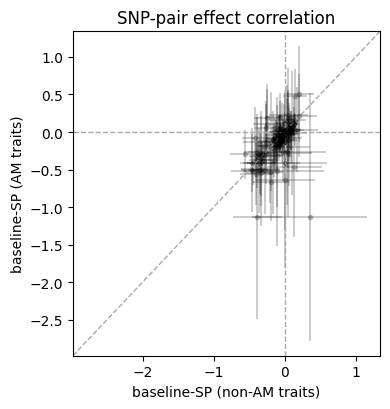

cor=0.510
# hypothesis: 136


,mean1,se1,mean2,se2,dif,dif_se,dif_z,dif_p,dif_fwer


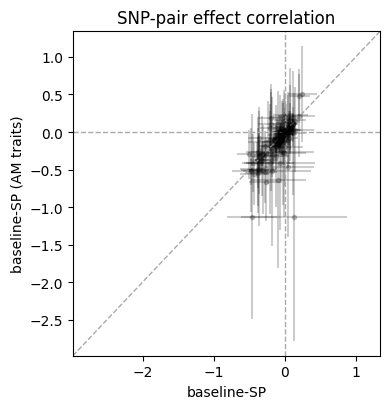

cor=0.589


In [12]:
# Correlation between different heritability models
df_list = []
for md1,md2 in [
    ['md_prox_gene_fct_all_ld.nam', 'md_prox_gene_fct_all_ld.am'],
    ['md_prox_gene_fct_all_ld', 'md_prox_gene_fct_all_ld.am'],
]:
    row_list = [x for x in dic_res_meta[md1]['omega'].index if x in dic_res_meta[md2]['omega'].index]
    df_plot = pd.DataFrame(index=row_list, columns=['mean1', 'se1', 'mean2', 'se2'], dtype=float)
    for row in row_list:
        df_plot.loc[row, ['mean1', 'se1']] = dic_res_meta[md1]['omega'].loc[row, ['cor', 'cor_se']].values
        df_plot.loc[row, ['mean2', 'se2']] = dic_res_meta[md2]['omega'].loc[row, ['cor', 'cor_se']].values
    df_plot['dif'] = df_plot['mean1'] - df_plot['mean2']
    df_plot['dif_se'] = np.sqrt(df_plot['se1']**2 + df_plot['se2']**2)
    df_plot['dif_z'] = df_plot['dif'] / df_plot['dif_se']
    df_plot['dif_p'] = ldspec.util.zsc2pval(df_plot['dif_z']) 
    df_plot['dif_fwer'] = df_plot['dif_p'] * 136
    print('# hypothesis: %d' % 136)
    df_list.append(df_plot)

    ind_select = df_plot['dif_fwer']<0.05
    display(df_plot.loc[ind_select])   
    
    plt.figure(figsize=[4,4.2])   
    plt.errorbar(df_plot.loc[~ind_select, 'mean1'], df_plot.loc[~ind_select, 'mean2'], 
                 xerr=df_plot.loc[~ind_select, 'se1']*1.96, yerr=df_plot.loc[~ind_select, 'se2']*1.96, 
                 fmt= '.', color='k', alpha=0.2, zorder=0)
    plt.errorbar(df_plot.loc[ind_select, 'mean1'], df_plot.loc[ind_select, 'mean2'], 
                 xerr=df_plot.loc[ind_select, 'se1']*1.96, yerr=df_plot.loc[ind_select, 'se2']*1.96, 
                 fmt= '.', color='C0', zorder=10)
    
    texts = []
    for row in df_plot.index[ind_select]:
        texts.append(plt.text(
            df_plot.loc[row, 'mean1'], df_plot.loc[row, 'mean2'], DIC_NAME[row], fontsize=10, zorder=10,
        ))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    
    # reference lines
    min_ = min(plt.xlim()[0], plt.ylim()[0])
    max_ = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([min_, max_], [0, 0], '--', linewidth=1, color='darkgrey', zorder=0)
    plt.plot([0, 0], [min_, max_], '--', linewidth=1, color='darkgrey', zorder=0)
    plt.plot([min_, max_], [min_, max_], '--', linewidth=1, color='darkgrey', zorder=0)
    plt.xlim([min_, max_])
    plt.ylim([min_, max_])
    
    plt.title('%s' % DIC_NAME['cor'])
    plt.xlabel(DIC_NAME[md1])
    plt.ylabel(DIC_NAME[md2])
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/compare.cor.%s.%s.pdf' % (md1,md2))
    plt.show()
#     break

    temp_df = pd.concat(df_list, axis=0)
    print('cor=%0.3f' % (np.corrcoef(temp_df['mean1'], temp_df['mean2'])[0,1]))


In [12]:
FIG_PATH

'/n/groups/price/martin/LDSPEC_data/results/fig_res.rv1'

### Old code